Modalidades detectadas: ['m0', 'm1', 'm2', 'm3', 'm4']


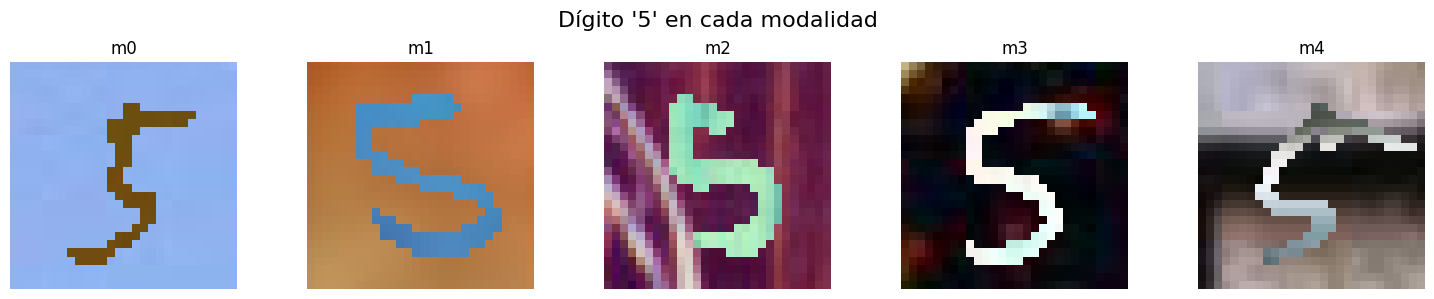

In [3]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Definir carpeta base (desde donde se ejecuta el notebook)
base_dir = "train"

# Detectar automáticamente todas las modalidades m0, m1, ..., m4
modalities = sorted([
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("m")
])

print("Modalidades detectadas:", modalities)

# Elegir qué dígito mostrar (0 al 9)
target_label = "5"  

images = []

# Recorrer cada modalidad
for mod in modalities:
    folder_path = os.path.join(base_dir, mod)

    # Filtrar imágenes con la etiqueta deseada 
    all_images = [
        f for f in os.listdir(folder_path)
        if f.endswith(".png") and f.split(".")[1] == target_label
    ]

    if not all_images:
        print(f"No se encontraron imágenes con etiqueta {target_label} en {mod}")
        continue

    # Elegir una imagen aleatoria de esa etiqueta
    img_file = random.choice(all_images)
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)
    images.append((mod, img))

# Mostrar las imágenes seleccionadas
plt.figure(figsize=(15, 3))
for idx, (mod, img) in enumerate(images):
    plt.subplot(1, len(images), idx + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{mod}")
    plt.axis("off")

plt.suptitle(f"Dígito '{target_label}' en cada modalidad", fontsize=16)
plt.tight_layout()
plt.show()

In [4]:
# Convertir las imágenes a escala de grises y luego a vectores de 784 dimensiones
X = np.array([np.array(img.convert('L')).flatten() for _, img in images])  # Convertir a escala de grises
y = np.array([target_label] * len(images))  # Etiquetas del dígito "5"

# Mostrar las formas para asegurarnos de que todo esté correcto
print("X shape:", X.shape)  # Debería ser (5, 784)
print("y shape:", y.shape)


X shape: (5, 784)
y shape: (5,)


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir las carpetas de entrenamiento y prueba
train_dir = "train"
test_dir = "test"

# Generadores de datos con normalización
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Generador para entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=64,
    class_mode='categorical'
)

# Generador para prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 300000 images belonging to 5 classes.
Found 50000 images belonging to 5 classes.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

x_train = []
y_train = []
x_test = []
y_test = []

# Bucle para recorrer el generador de entrenamiento
for img_batch, label_batch in train_generator:
    for img, label in zip(img_batch, label_batch):
        gray_img = np.array(Image.fromarray(img.astype('uint8')).convert('L'))  # Convertir a escala de grises
        x_train.append(gray_img.flatten())  # Aplanar la imagen a un vector
        y_train.append(np.argmax(label))  # Convertir etiquetas one-hot a índices

    if len(x_train) >= len(train_generator.filenames):  # Terminar después de procesar todas las imágenes
        break

# Bucle para recorrer el generador de prueba
for img_batch, label_batch in test_generator:
    for img, label in zip(img_batch, label_batch):
        gray_img = np.array(Image.fromarray(img.astype('uint8')).convert('L'))  # Convertir a escala de grises
        x_test.append(gray_img.flatten())  # Aplanar la imagen a un vector
        y_test.append(np.argmax(label))  # Convertir etiquetas one-hot a índices

    if len(x_test) >= len(test_generator.filenames):  # Terminar después de procesar todas las imágenes
        break

# Convertir las listas a arrays de numpy
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Verificar las formas
print("x_train shape:", x_train.shape)  
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)  
print("y_test shape:", y_test.shape)

# 3. Entrenar el modelo K-NN
k = 3  # Número de vecinos
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)

# 4. Evaluar el modelo
y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precisión del modelo K-NN: {accuracy * 100:.2f}%")


x_train shape: (300000, 784)
y_train shape: (300000,)
x_test shape: (50000, 784)
y_test shape: (50000,)
Precisión del modelo K-NN: 37.02%
